# Code for simulation of Raman heterodyne like processes

## Getting setup

### Import required python libraries

In [1]:
import sympy as sym
sym.init_printing()

import numpy as np
from scipy import integrate,signal

import math
from math import pi
#from sympy.functions import Heaviside, sin, cos, sqrt


import matplotlib.pyplot as plt
from sympy import I, Matrix, symbols
from sympy.physics.quantum import TensorProduct,Dagger
import scipy.optimize

import qutip

%load_ext cython

### Some things to help us make Liovillian superoperators
- Uses an approach very like qutip and the qotoolbox, reading the documention for those two packages might help make sense of spre, spost, etc
- s13 etc. are the atomic operators like |1><3| etc

In [2]:
def spre(m):
    return TensorProduct(sym.eye(m.shape[0]),m)

def spost(m):
    return TensorProduct(m.T,sym.eye(m.shape[0]))

def collapse(c):
    temp = Dagger(c)*c/2
    return spre(c)*spost(Dagger(c))-spre(temp)-spost(temp)


s13=Matrix([[0,0,1],[0,0,0],[0,0,0]])
s23=Matrix([[0,0,0],[0,0,1],[0,0,0]])
s12=Matrix([[0,1,0],[0,0,0],[0,0,0]])

s31=s13.T
s32=s23.T
s21=s12.T

s11 = s12*s21
s22 = s21*s12
s33 = s31*s13



### Checking spre and spost agree with qutip

Note: This notebook uses Frotran (colum first) order when flattening matricies.

In [3]:
sigmay = Matrix([[0, -I], [I, 0 ]])
sigmay, qutip.sigmay()

(Matrix([
 [0, -I],
 [I,  0]]),
 Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j]
  [0.+1.j 0.+0.j]])

In [4]:
qutip.sigmay()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j 0.-1.j]
 [0.+1.j 0.+0.j]]

In [5]:
spre(sigmay),qutip.spre(qutip.sigmay())

(Matrix([
 [0, -I, 0,  0],
 [I,  0, 0,  0],
 [0,  0, 0, -I],
 [0,  0, I,  0]]),
 Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
 Qobj data =
 [[0.+0.j 0.-1.j 0.+0.j 0.+0.j]
  [0.+1.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.-1.j]
  [0.+0.j 0.+0.j 0.+1.j 0.+0.j]])

In [6]:
spost(sigmay),qutip.spost(qutip.sigmay())

(Matrix([
 [ 0,  0, I, 0],
 [ 0,  0, 0, I],
 [-I,  0, 0, 0],
 [ 0, -I, 0, 0]]),
 Quantum object: dims = [[[2], [2]], [[2], [2]]], shape = (4, 4), type = super, isherm = True
 Qobj data =
 [[0.+0.j 0.+0.j 0.+1.j 0.+0.j]
  [0.+0.j 0.+0.j 0.+0.j 0.+1.j]
  [0.-1.j 0.+0.j 0.+0.j 0.+0.j]
  [0.+0.j 0.-1.j 0.+0.j 0.+0.j]])

### The symbolic variables we will use
- TODO: explain what they all are


In [7]:
delta2,delta3 = sym.symbols('delta_2 delta_3',real=True)
gamma13,gamma23,gamma2d,gamma3d,nbath,gammamu = sym.symbols('gamma_13 gamma_23 gamma_2d gamma_3d n_b gamma_mu', real=True, negative=False)
omegao,omegam = sym.symbols('Omega_o Omega_mu', real=True, negative=False)
rho11,rho12,rho13,rho21,rho22,rho23,rho31,rho32,rho33 = sym.symbols('rho_11 rho_12 rho_13 rho_21 rho_22 rho_23 rho_31 rho_32 rho_33')

a = sym.symbols('a')
ar,ai = sym.symbols('a_r a_i',real=True)
g = sym.symbols('g',real=True, negative=False)

## Analytic calculations - Liovillian

In [8]:
H =  omegam*s21 + omegao*s32 + g*a*s31
H = H + Dagger(H)
H = H + delta2*s22 + delta3*s33
LH = -I*spre(H)+I*spost(H) 

L21 = gammamu*(nbath+1)*collapse(s12)
L12 = gammamu*(nbath)*collapse(s21)
L32 = gamma23*collapse(s23)
L31 = gamma13*collapse(s13)
L22 = gamma2d*collapse(s22)
L33 = gamma3d*collapse(s33)

L = LH + L21 + L12 + L32 + L31 + L22 + L33

#because Trace(rho) = 1 we can replace first row as below
#this gives us a matrix that can be inverted
L = L.row_insert(0,Matrix([[1,0,0,0,1,0,0,0,1]]))
L.row_del(1)

# The condition for the steady state is now L*rho=V
# where V = [1,0,0, 0,0,0, 0,0,0].T

### Expressions for the various operators

In [9]:
L

⎡   1                       0                                     0           
⎢                                                                             
⎢                 γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                              
⎢-ⅈ⋅Ωₘᵤ   -ⅈ⋅δ₂ - ──── - ─────── - ─────────────                -ⅈ⋅Ωₒ         
⎢                  2        2            2                                    
⎢                                                                             
⎢                                                         γ₁₃   γ₂₃   γ_3d   γ
⎢-ⅈ⋅a⋅g                   -ⅈ⋅Ωₒ                   -ⅈ⋅δ₃ - ─── - ─── - ──── - ─
⎢                                                          2     2     2      
⎢                                                                             
⎢                                                                             
⎢ ⅈ⋅Ωₘᵤ                     0                                     0           
⎢                                                   

In [10]:
H

⎡            _⎤
⎢ 0   Ωₘᵤ  g⋅a⎥
⎢             ⎥
⎢Ωₘᵤ  δ₂   Ωₒ ⎥
⎢             ⎥
⎣a⋅g  Ωₒ   δ₃ ⎦

In [11]:
#rho flattened out to a vector
rho = Matrix([[rho11,rho21,rho31],[rho12,rho22,rho32],[rho13,rho23,rho33]])
rho = 1*rho.T #because we are using "fortran" style matrix flatteneing
rho[:]
rhoflat = 1*rho.T 
rhoflat = rhoflat[:]
rhoflat

In [12]:
L[:,0:3] #because the matrix gets clipped when exporting to PDF

⎡   1                       0                                     0           
⎢                                                                             
⎢                 γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                              
⎢-ⅈ⋅Ωₘᵤ   -ⅈ⋅δ₂ - ──── - ─────── - ─────────────                -ⅈ⋅Ωₒ         
⎢                  2        2            2                                    
⎢                                                                             
⎢                                                         γ₁₃   γ₂₃   γ_3d   γ
⎢-ⅈ⋅a⋅g                   -ⅈ⋅Ωₒ                   -ⅈ⋅δ₃ - ─── - ─── - ──── - ─
⎢                                                          2     2     2      
⎢                                                                             
⎢ ⅈ⋅Ωₘᵤ                     0                                     0           
⎢                                                                             
⎢γₘᵤ⋅n_b                  ⅈ⋅Ωₘᵤ                     

In [13]:
L[:,3:6]

⎡                  0                          1                               
⎢                                                                             
⎢                  0                        ⅈ⋅Ωₘᵤ                             
⎢                                                                             
⎢                  0                          0                               
⎢                                                                             
⎢       γ_2d   γₘᵤ⋅n_b   γₘᵤ⋅(n_b + 1)                                        
⎢ⅈ⋅δ₂ - ──── - ─────── - ─────────────      -ⅈ⋅Ωₘᵤ                            
⎢        2        2            2                                              
⎢                                                                             
⎢               -ⅈ⋅Ωₘᵤ                  -γₘᵤ⋅(n_b + 1)                        
⎢                                                                             
⎢                                                   

In [14]:
L[:,6:]

⎡                0                                            0               
⎢                                                                             
⎢                0                                          ⅈ⋅a⋅g             
⎢                                                                             
⎢                0                                            0               
⎢                                                                             
⎢              ⅈ⋅Ωₒ                                           0               
⎢                                                                             
⎢                0                                           ⅈ⋅Ωₒ             
⎢                                                                             
⎢                0                                            0               
⎢                                                                             
⎢       γ₁₃   γ₂₃   γ_3d   γₘᵤ⋅n_b                  

In [15]:

rhoflat[6]

### We can transform the "basis" we use for our density matrix vector so that all the elements are real

In [16]:
#change of variables to make things real to make it a bit faster maybe
CtoR = Matrix([[2,0,0,0,0,0,0,0,0],
               [0,0,0,0,2,0,0,0,0],
               [0,0,0,0,0,0,0,0,2],
               [0,1,0,1,0,0,0,0,0],
               [0,I,0,-I,0,0,0,0,0],
               [0,0,1,0,0,0,1,0,0],
               [0,0,I,0,0,0,-I,0,0],
               [0,0,0,0,0,1,0,1,0],
               [0,0,0,0,0,I,0,-I,0]
              ])
CtoR=CtoR/2

### The new organisation for our density matrix

In [17]:
#these is our new state vector 
t = CtoR*Matrix(rhoflat)
t

⎡      ρ₁₁      ⎤
⎢               ⎥
⎢      ρ₂₂      ⎥
⎢               ⎥
⎢      ρ₃₃      ⎥
⎢               ⎥
⎢   ρ₁₂   ρ₂₁   ⎥
⎢   ─── + ───   ⎥
⎢    2     2    ⎥
⎢               ⎥
⎢  ⅈ⋅ρ₁₂   ⅈ⋅ρ₂₁⎥
⎢- ───── + ─────⎥
⎢    2       2  ⎥
⎢               ⎥
⎢   ρ₁₃   ρ₃₁   ⎥
⎢   ─── + ───   ⎥
⎢    2     2    ⎥
⎢               ⎥
⎢  ⅈ⋅ρ₁₃   ⅈ⋅ρ₃₁⎥
⎢- ───── + ─────⎥
⎢    2       2  ⎥
⎢               ⎥
⎢   ρ₂₃   ρ₃₂   ⎥
⎢   ─── + ───   ⎥
⎢    2     2    ⎥
⎢               ⎥
⎢  ⅈ⋅ρ₂₃   ⅈ⋅ρ₃₂⎥
⎢- ───── + ─────⎥
⎣    2       2  ⎦

### The Liovillian in this new basis

In [18]:
Lreal = sym.simplify(CtoR*L*CtoR.inv())
Lreal = Lreal.subs(a,ar+I*ai)
Lreal

⎡   1           1             1                 0                       0     
⎢                                                                             
⎢γₘᵤ⋅n_b  -γₘᵤ⋅(n_b + 1)     γ₂₃                0                     2⋅Ωₘᵤ   
⎢                                                                             
⎢   0           0         -γ₁₃ - γ₂₃            0                       0     
⎢                                                                             
⎢                                       γ_2d             γₘᵤ                  
⎢   0           0             0       - ──── - γₘᵤ⋅n_b - ───           -δ₂    
⎢                                        2                2                   
⎢                                                                             
⎢                                                               γ_2d          
⎢  Ωₘᵤ         -Ωₘᵤ           0                 δ₂            - ──── - γₘᵤ⋅n_b
⎢                                                   

In [19]:
# A sanity check 
# sym.simplify(CtoR.inv()*Lreal*CtoR*Matrix(rhoflat)-(L*Matrix(rhoflat)).subs(a,ar+I*ai))

### C-code from our analytic expressions for the two different versions of the Liovillan
- this is copied and pasted into some of the functions below

In [20]:
from sympy.printing import print_ccode
Lflat = 1*L.T
Lflat = Lflat[:]
print_ccode(Lflat)

print("-----------")
#because this is destined for cython it's in row-major order
Lflatreal = 1*Lreal.T
Lflatreal = Lflatreal[:]
print_ccode(Lflatreal)
print("----------")
for k in range(81):
    print("L[%d] = "%(k,),end="")
    print_ccode(Lflatreal[k])

// Not supported in C:
// conjugate
[1, -I*Omega_mu, -I*a*g, I*Omega_mu, gamma_mu*n_b, 0, I*g*conjugate(a), 0, 0, 0, -I*delta_2 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_mu*n_b - 1.0/2.0*gamma_mu*(n_b + 1), -I*Omega_o, 0, I*Omega_mu, 0, 0, I*g*conjugate(a), 0, 0, -I*Omega_o, -I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, 0, 0, I*Omega_mu, 0, 0, I*g*conjugate(a), 0, 0, 0, I*delta_2 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_mu*n_b - 1.0/2.0*gamma_mu*(n_b + 1), -I*Omega_mu, -I*a*g, I*Omega_o, 0, 0, 1, I*Omega_mu, 0, -I*Omega_mu, -gamma_mu*(n_b + 1), -I*Omega_o, 0, I*Omega_o, 0, 0, 0, I*Omega_mu, -I*g*conjugate(a), -I*Omega_o, I*delta_2 - I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1), 0, 0, I*Omega_o, 0, 0, 0, I*Omega_o, 0, 0, I*delta_3 - 1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, -I*Omega_mu, -I*a*g, 0, I*a*g, 0, 0, I*Omega_o, 0, -I*Omega_mu, -I*delta_2 +

## Numerical code for steady state

### Python code
- Using analytic expressions above
- The code below is much slower than the cython version below, but useful for confirming correctness of cython version.

In [21]:
Lfunc = sym.lambdify((a,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),L)

Lrealfunc = sym.lambdify((ar,ai,delta2, delta3, gamma13, gamma23, gamma2d, gamma3d, nbath,gammamu,omegao,omegam,g),Lreal)

# finds the steady state density matrix
# p is a python dictionary full of parameters

def steady_rho(p):
    
    Lmatrix = Lfunc(p['a'],p['delta2'],p['delta3'],p['gamma13'],
                               p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
                               p['gammamu'],p['omegao'],p['omegam'],p['g'])
    
    #return Lmatrix
    rho = np.linalg.solve(Lmatrix.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
    return np.reshape(rho,(3,3),order='F')

# this code is commented out because it has been replaced by cython version
# will leave it for future sanity checks if 

# Just the rho13 element of the density matrix:

# def steady_rho13_older(p):
#     Lmatrix = Lfunc(p['a'],p['delta2'],p['delta3'],p['gamma13'],
#                                p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
#                                p['gammamu'],p['omegao'],p['omegam'],p['g'])
#     #return Lmatrix
#     rho = np.linalg.solve(Lmatrix.astype('complex128'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)
#     return rho[6]

# # another version 
# def steady_rho13_old(p):
#     Lmatrix =  Lrealfunc(np.real(p['a']),np.real(p['a']),p['delta2'],p['delta3'],p['gamma13'],
#                                p['gamma23'],p['gamma2d'],p['gamma3d'],p['nbath'],
#                                p['gammamu'],p['omegao'],p['omegam'],p['g'])
#     rho = np.linalg.solve(Lmatrix.astype('double'),np.matrix([[1,0,0,0,0,0,0,0,0]]).T)    
#     return rho[5]+1j*rho[6]

### Cython versions
 Implemented in cython to make it (much) faster.

In [22]:
%%cython --compile-args=-fopenmp --link-args=-fopenmp --verbose --force
#### %%cython -a # this gives "highligted" output

#cython: boundscheck=False, wraparound=False, nonecheck=False
cimport cython
import numpy as np
from cython.parallel cimport prange
cimport scipy.linalg.cython_lapack as lapack
import numpy as np
from libc.math cimport exp


cdef int nextpow2(int x):
    cdef int n=1
    while(True):
        if n>=x:
            return n
        n=2*n

def steady_rho13(p):
    cdef double a_r,a_i,delta_2,delta_3,gamma_13,gamma_23,gamma_2d,gamma_3d,n_b,gamma_mu,Omega_o,Omega_mu,g
    cdef double L[81]
    cdef double V[9]
    cdef int n = 9
    cdef double complex a
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9 
    cdef int nrhs = 1
    cdef int workspace[9]
    
    V[:]= [1,0,0, 0,0,0, 0,0,0]
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23'] 
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao'] 
    Omega_mu = p['omegam']
    g = p['g']
 #   with nogil: # to make sure it's not doing any slow python calls
    L[:] = (1, gamma_mu*n_b, 0, 0, Omega_mu, a_i*g, a_r*g, 0, 0, 1, -gamma_mu*(n_b + 1), 0, 0, -Omega_mu, 0, 0, 0, Omega_o, 1, gamma_23, -gamma_13 - gamma_23, 0, 0, -a_i*g, -a_r*g, 0, -Omega_o, 0, 0, 0, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, delta_2, 0, Omega_o, a_i*g, a_r*g, 0, 2*Omega_mu, 0, -delta_2, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, -Omega_o, 0, a_r*g, -a_i*g, 0, 0, 2*a_i*g, 0, Omega_o, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, delta_3, 0, -Omega_mu, 0, 0, 2*a_r*g, -Omega_o, 0, -delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, Omega_mu, 0, 0, 0, 0, -a_i*g, -a_r*g, 0, -Omega_mu, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1), -delta_2 + delta_3, 0, -2*Omega_o, 2*Omega_o, -a_r*g, a_i*g, Omega_mu, 0, delta_2 - delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1))
    
    lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    return V[5]+1j*V[6]


cdef double complex steady_rho13_lots_of_args(double a_r,
                               double a_i,
                               double delta_2,
                               double delta_3,
                               double gamma_13,
                               double gamma_23,
                               double gamma_2d,
                               double gamma_3d,
                               double n_b,
                               double gamma_mu,
                               double Omega_o,
                               double Omega_mu,
                               double g) nogil:
    cdef double L[81]
    cdef double V[9]
    cdef int n = 9
    cdef double complex a
    cdef int info
    cdef int lda = 9
    cdef int ldb = 9 
    cdef int nrhs = 1
    cdef int workspace[9]
    cdef int k
  
    # Unfortunately cant use this syntax if we dont have dont have GIL
    #V[:] = [1,0,0, 0,0,0, 0,0,0]
    #L[:] = (1, gamma_mu*n_b, 0, 0, Omega_mu, a_i*g, a_r*g, 0, 0, 1, -gamma_mu*(n_b + 1), 0, 0, -Omega_mu, 0, 0, 0, Omega_o, 1, gamma_23, -gamma_13 - gamma_23, 0, 0, -a_i*g, -a_r*g, 0, -Omega_o, 0, 0, 0, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, delta_2, 0, Omega_o, a_i*g, a_r*g, 0, 2*Omega_mu, 0, -delta_2, -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu, -Omega_o, 0, a_r*g, -a_i*g, 0, 0, 2*a_i*g, 0, Omega_o, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, delta_3, 0, -Omega_mu, 0, 0, 2*a_r*g, -Omega_o, 0, -delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b, Omega_mu, 0, 0, 0, 0, -a_i*g, -a_r*g, 0, -Omega_mu, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1), -delta_2 + delta_3, 0, -2*Omega_o, 2*Omega_o, -a_r*g, a_i*g, Omega_mu, 0, delta_2 - delta_3, -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1))
    
    for k in range(9):
        V[k] = 0
    V[0] = 1
    
    L[0] = 1
    L[1] = gamma_mu*n_b
    L[2] = 0
    L[3] = 0
    L[4] = Omega_mu
    L[5] = a_i*g
    L[6] = a_r*g
    L[7] = 0
    L[8] = 0
    L[9] = 1
    L[10] = -gamma_mu*(n_b + 1)
    L[11] = 0
    L[12] = 0
    L[13] = -Omega_mu
    L[14] = 0
    L[15] = 0
    L[16] = 0
    L[17] = Omega_o
    L[18] = 1
    L[19] = gamma_23
    L[20] = -gamma_13 - gamma_23
    L[21] = 0
    L[22] = 0
    L[23] = -a_i*g
    L[24] = -a_r*g
    L[25] = 0
    L[26] = -Omega_o
    L[27] = 0
    L[28] = 0
    L[29] = 0
    L[30] = -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu
    L[31] = delta_2
    L[32] = 0
    L[33] = Omega_o
    L[34] = a_i*g
    L[35] = a_r*g
    L[36] = 0
    L[37] = 2*Omega_mu
    L[38] = 0
    L[39] = -delta_2
    L[40] = -1.0/2.0*gamma_2d - gamma_mu*n_b - 1.0/2.0*gamma_mu
    L[41] = -Omega_o
    L[42] = 0
    L[43] = a_r*g
    L[44] = -a_i*g
    L[45] = 0
    L[46] = 0
    L[47] = 2*a_i*g
    L[48] = 0
    L[49] = Omega_o
    L[50] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b
    L[51] = delta_3
    L[52] = 0
    L[53] = -Omega_mu
    L[54] = 0
    L[55] = 0
    L[56] = 2*a_r*g
    L[57] = -Omega_o
    L[58] = 0
    L[59] = -delta_3
    L[60] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*n_b
    L[61] = Omega_mu
    L[62] = 0
    L[63] = 0
    L[64] = 0
    L[65] = 0
    L[66] = -a_i*g
    L[67] = -a_r*g
    L[68] = 0
    L[69] = -Omega_mu
    L[70] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1)
    L[71] = -delta_2 + delta_3
    L[72] = 0
    L[73] = -2*Omega_o
    L[74] = 2*Omega_o
    L[75] = -a_r*g
    L[76] = a_i*g
    L[77] = Omega_mu
    L[78] = 0
    L[79] = delta_2 - delta_3
    L[80] = -1.0/2.0*gamma_13 - 1.0/2.0*gamma_23 - 1.0/2.0*gamma_2d - 1.0/2.0*gamma_3d - 1.0/2.0*gamma_mu*(n_b + 1)
    lapack.dgesv(&n,&nrhs,L,&lda,workspace,V,&ldb,&info)
    return V[5]+1j*V[6]





# Steady state an ensemble of atoms, returns a matrix of rho13 values as well as the list of 
# weights from the inhomogeneous broadening distribution.
# Convolve the two to get simulate single pass raman heterodyne signal as a function of frequency

def ensemble_steady_rho13(p,delta2vals,delta3vals):
    cdef double a_r,a_i,delta_2,delta_3,gamma_13,gamma_23,gamma_2d,gamma_3d,n_b,gamma_mu,Omega_o,Omega_mu,g
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23'] 
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao'] 
    Omega_mu = p['omegam']
    g = p['g']
    
    cdef int ii
    cdef int jj
    
    cdef double m2 = p['mean_delta2']
    cdef double sd2 = p['sd_delta2']
    cdef double m3 = p['mean_delta3']
    cdef double sd3 = p['sd_delta3']
    #print(sd3)
    
    cdef double [:] delta2valsv = delta2vals
    cdef double [:] delta3valsv = delta3vals
    
    cdef int ndelta2 = len(delta2vals)
    cdef int ndelta3 = len(delta3vals)
    
    cdef double df2 = delta2valsv[1]-delta2valsv[0]
    cdef double df3 = delta3valsv[1]-delta3valsv[0]
    
    coh13 = np.zeros((ndelta2,ndelta3),dtype='complex128') #make numpy array
    cdef double complex [:,:] coh13v = coh13 #make cython  "view" of the data
    
    w = np.zeros((ndelta2,ndelta3),dtype='complex128') #make numpy array for gaussian weights
    cdef double complex [:,:] wv = w #make cython  "view" of the data
    
    for ii in prange(ndelta2, nogil=True):
    #for ii in range(ndelta2):    
        delta_2 = delta2valsv[ii]
        for jj in range(ndelta3):
            delta_3 = delta3valsv[jj]
            coh13v[ii,jj] = steady_rho13_lots_of_args(a_r,
                               a_i,
                               delta_2,
                               delta_3,
                               gamma_13,
                               gamma_23,
                               gamma_2d,
                               gamma_3d,
                               n_b,
                               gamma_mu,
                               Omega_o,
                               Omega_mu,
                               g)
            wv[ii,jj] = 1.0/(2*3.14159265358979323846*sd3*sd2) * exp(-(delta_2-m2)**2/(2*sd2*sd2)-(delta_3-m3)**2/(2*sd3*sd3))
    return (coh13,w)

# Integrate over an ensemble using simpson's rule
cpdef ensemble_steady_rho13_integrated(p,double df):
    #cdef double df = 200e3 #frequency discretization
    cdef double a_r,a_i,delta_2,delta_3,gamma_13,gamma_23,gamma_2d,gamma_3d,n_b,gamma_mu,Omega_o,Omega_mu,g
    a = p['a']
    a_r = a.real
    a_i = a.imag
    delta_2 = p['delta2']
    delta_3 = p['delta3']
    gamma_13 = p['gamma13']
    gamma_23 = p['gamma23'] 
    gamma_2d = p['gamma2d']
    gamma_3d = p['gamma3d']
    n_b = p['nbath']
    gamma_mu = p['gammamu']
    Omega_o = p['omegao'] 
    Omega_mu = p['omegam']
    g = p['g']
    
    cdef int ii
    cdef int jj
    
    cdef double m2 = p['mean_delta2']
    cdef double sd2 = p['sd_delta2']
    cdef double m3 = p['mean_delta3']
    cdef double sd3 = p['sd_delta3']
    
    cdef int w2,w3
    
    cdef int ndelta2 = 2*int(3*sd2/df)+1
    cdef int ndelta3 = 2*int(3*sd3/df)+1
    # print(ndelta2,ndelta3) 

    delta2vals = np.linspace(-3,3,ndelta2)*sd2+m2
    delta3vals = np.linspace(-3,3,ndelta3)*sd3+m3
   
    cdef double [:] delta2valsv = delta2vals
    cdef double [:] delta3valsv = delta3vals

    
    simpsonw2 = np.empty((ndelta2,),dtype='int32')
    cdef int [:] simpsonw2v = simpsonw2 
    simpsonw3 = np.empty((ndelta3,),dtype='int32')
    cdef int [:] simpsonw3v = simpsonw3   
    
    ii=0
    while(ii<(ndelta2-1)):
        simpsonw2v[ii]=2
        ii+=1
        simpsonw2v[ii]=4
        ii+=1
    simpsonw2v[0]=1
    simpsonw2v[ndelta2-1]=1
          
    ii=0
    while(ii<(ndelta3-1)):
        simpsonw3v[ii]=2
        ii+=1
        simpsonw3v[ii]=4
        ii+=1
    simpsonw3v[0]=1
    simpsonw3v[ndelta3-1]=1

    
    
    cdef double complex z = 0
    cdef double sum_r = 0
    cdef double sum_i = 0
    cdef double gaussie
    for ii in prange(ndelta2,nogil=True):
    #for ii in range(ndelta2):
        delta_2 = delta2valsv[ii]
        w2 = simpsonw2v[ii]
        for jj in range(ndelta3):
            delta_3 = delta3valsv[jj]
            w3 = simpsonw3v[jj]
            gaussie = 1.0/(2*3.14159265358979323846*sd3*sd2) * exp(-(delta_2-m2)**2/(2*sd2*sd2)-(delta_3-m3)**2/(2*sd3*sd3))
            z = steady_rho13_lots_of_args(a_r,
                               a_i,
                               delta_2,
                               delta_3,
                               gamma_13,
                               gamma_23,
                               gamma_2d,
                               gamma_3d,
                               n_b,
                               gamma_mu,
                               Omega_o,
                               Omega_mu,
                               g)*gaussie*w2*w3
            #this is because cython doesn't know how to automatically do reductions for 
            #complex variables but seems to for doubles
            sum_r += z.real
            sum_i += z.imag
    return (sum_r+sum_i*1j)*df*df/9.0


[1/1] Cythonizing /home/jevon/.cache/ipython/cython/_cython_magic_74ad2fd20a76c5ac71360d0e03708b36.pyx
building '_cython_magic_74ad2fd20a76c5ac71360d0e03708b36' extension
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -g -fdebug-prefix-map=/build/python3.6-EKG1lX/python3.6-3.6.5=. -specs=/usr/share/dpkg/no-pie-compile.specs -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/home/jevon/.local/lib/python3.6/site-packages/numpy/core/include -I/usr/include/python3.6m -c /home/jevon/.cache/ipython/cython/_cython_magic_74ad2fd20a76c5ac71360d0e03708b36.c -o /home/jevon/.cache/ipython/cython/home/jevon/.cache/ipython/cython/_cython_magic_74ad2fd20a76c5ac71360d0e03708b36.o -fopenmp
x86_64-linux-gnu-gcc -pthread -shared -Wl,-O1 -Wl,-Bsymbolic-functions -Wl,-Bsymbolic-functions -specs=/usr/share/dpkg/no-pie-link.specs -Wl,-z,relro -Wl,-Bsymbolic-functions -specs=/usr/share/dpkg/no-pie-link.specs -Wl,-z,relro -g -fdeb

## Calculations - just atoms

### Single pass - no inhomogeneous broadening
#### Weird behavior -- driving both microwave and optical pump hard 
- Signal persists at very high microwave detuning 
- EIT like features

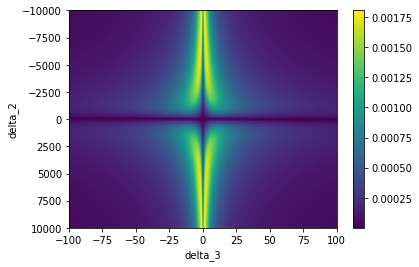

In [23]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 10e6
p['omegam'] = 10e6
p['g'] = 0.

# Code currently requires these, even if we're not interested in
# inhomogeneous brodening for the moment
p['mean_delta2']=0 
p['sd_delta2']=20e6/2.355 #2.355 is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=300e6/2.355

delta2vals = np.linspace(-10000e6,10000e6,501)
delta3vals = np.linspace(-100e6,100e6,501)

coh,_ = ensemble_steady_rho13(p,delta2vals,delta3vals)       

#plt.rcParams['figure.figsize'] = [10, 4]
plt.imshow(np.abs(coh),extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar();

#### Strong optical pump, weak microwaves

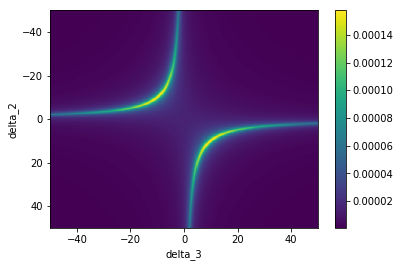

In [24]:
#some default parameters
p = {}
p['a'] = 0.0
p['delta2'] = 0.0
p['delta3'] = 0.0
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 10e6
p['omegam'] = 1e3
p['g'] = 0.0


# Code currently requires these, even if we're not interested in
# inhomogeneous brodening for the moment
p['mean_delta2']=0 
p['sd_delta2']=20e6/2.355 #2.355 is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=300e6/2.355


delta2vals = np.linspace(-50e6,50e6,505)
delta3vals = np.linspace(-50e6,50e6,505)

     
coh,_ = ensemble_steady_rho13(p,delta2vals,delta3vals)       
coh = np.abs(coh)

#plt.rcParams['figure.figsize'] = [10, 4]
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar();


#### Strong microwaves, weak optical pump

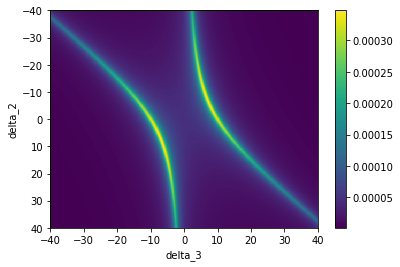

In [25]:
#some default parameters
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 10e6
p['g'] = 0.

# Code currently requires these, even if we're not interested in
# inhomogeneous brodening for the moment
p['mean_delta2']=0 
p['sd_delta2']=20e6/2.355 #2.355 is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=300e6/2.355

delta2vals = np.linspace(-40e6,40e6,501)
delta3vals = np.linspace(-40e6,40e6,501)

   
coh,_ = ensemble_steady_rho13(p,delta2vals,delta3vals)       
coh = np.abs(coh)


#plt.rcParams['figure.figsize'] = [8, 4]
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar();

#### Both microwaves and optical pump weak

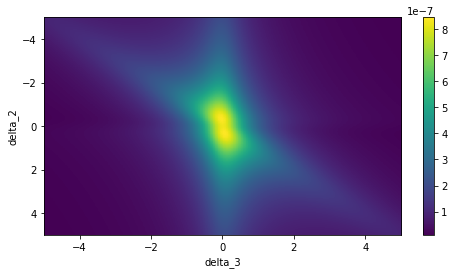

In [26]:
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./1e-6
p['gamma3d'] = 1./1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 1e3
p['omegam'] = 1e3
p['g'] = 0.

# Code currently requires these, even if we're not interested in
# inhomogeneous brodening for the moment
p['mean_delta2']=0 
p['sd_delta2']=20e6/2.355 #2.355 is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=300e6/2.355

delta2vals = np.linspace(-5e6,5e6,501)
delta3vals = np.linspace(-5e6,5e6,501)

coh,_ = ensemble_steady_rho13(p,delta2vals,delta3vals)       
coh = np.abs(coh)

plt.rcParams['figure.figsize'] = [8, 4]
plt.imshow(coh,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.colorbar();

### Single pass signal with inhomogneous broadening



In [27]:
%%time 
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1./22e-3
p['gamma23'] = 1./22e-3
p['gamma2d'] = 1./.1e-6 #unrealistically fast, but makes calculations easier
p['gamma3d'] = 1./.1e-6
p['nbath'] = 20
p['gammamu'] = 1./((p['nbath']+1)*11e-3)
p['omegao'] = 60e6
p['omegam'] = 1e3
p['g'] = 0.

p['mean_delta2']=0
p['sd_delta2']=20e6
p['mean_delta3']=0
p['sd_delta3']=20e6 #not realistic but makes calculations faster

delta2vals = np.linspace(-100e6,100e6,1000)
delta3vals = np.linspace(-1000e6,1000e6,10000)

(coh13,w) = ensemble_steady_rho13(p,delta2vals,delta3vals)
sig = signal.fftconvolve(coh13,w)

CPU times: user 18.1 s, sys: 1.5 s, total: 19.6 s
Wall time: 7.48 s


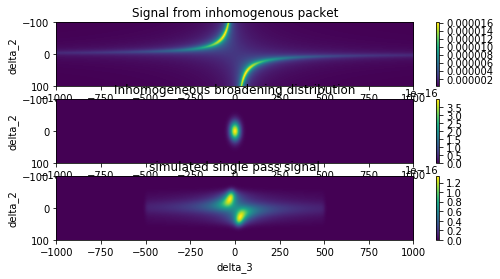

In [28]:
#plt.rcParams['figure.figsize'] = [10, 20]
plt.subplot(3,1,1)        
plt.imshow(np.abs(coh13),extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.title('Signal from inhomogenous packet')
plt.colorbar();

plt.subplot(3,1,2)
plt.imshow(w.real,extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.title('Inhomogeneous broadening distribution')
plt.colorbar();

plt.subplot(3,1,3)
plt.imshow(np.abs(sig),extent = [min(delta3vals)/1e6,max(delta3vals)/1e6,max(delta2vals)/1e6,min(delta2vals)/1e6],aspect='auto')
plt.ylabel('delta_2')
plt.xlabel('delta_3')
plt.title('simulated single pass signal')
plt.colorbar();

## Introducing cavity dynamics

The (classical) equations of motion of the cavity mode amplitude are given by 
$$
\frac{d}{dt} a = -i \delta_c a -i\sum_k g_k \sigma_{13,k} - \frac{(\kappa_i+\kappa_c)}{2}a - \sqrt{\kappa_c} a_{in}
$$
Here $\kappa_i$ is the intrisic loss rate of our cavity and $\kappa_c$ is the coupling induced loss.

Defining 
$$
S_{13}(a)= \sum_k g_k \sigma_{13,k}
$$ 
We write $S_{13}(a)$ to remind us (explicitly) that the atoms states are a function of the cavity mode amplitude $a$.

Because we won't drive $a$ this becomes
$$
\frac{d}{dt} a = -i \delta_c a
-i S_{13}(a)
- \frac{(\kappa_i+\kappa_c)}{2}a 
$$
So to find the steady state of the cavity we need to find the roots of the function
$$
f(a) = -i \delta_c a
-i S_{13}(a)
- \frac{(\kappa_i+\kappa_c)}{2}a 
$$

In [29]:
def ffunc(p):
    df = p['df']
    a = p['a']
    N = p['N']
    g = p['g']
    deltac = p['deltac']
    kappa = p['kappaoi']+p['kappaoc']
    S13 = N*g*ensemble_steady_rho13_integrated(p,df)
    return -1j*deltac*a - 1j*S13 - kappa/2*a

# the same function but in a form that maps a 2d vector to a 2d vector rather than complex -> complex
def ffunc_for_root(avec,p):
    a = avec[0]+1j*avec[1]
    # print(a)
    p['a']=a
    f = ffunc(p)
    print("a=",avec.real,avec.imag)
    return [f.real,f.imag]

def steadya(p):
    # use value of a as steady state
    a = p['a']
    avec = [a.real,a.imag]
    df = p['df']
    result = scipy.optimize.root(ffunc_for_root,avec,args=(p))
    if not result.success:
        print(result)
        raise(AssertionError('The bloody thing didn\'t converge: '+result.message))
    #update p['a'] why not?
    a = result.x[0]+1j*result.x[1]
    p['a']=a
    return a


These aren't very realistic parameters, but lead to fast calcs

In [30]:
df = 0.1
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.
p['gamma13'] = 1
p['gamma23'] = 1
p['gamma2d'] = 1
p['gamma3d'] = 1
p['nbath'] = 2
p['gammamu'] = 1
p['omegao'] = 1
p['omegam'] = .01
p['g'] = 1.
p['N'] = 1
p['deltac']=0
p['kappaoi']=1
p['kappaoc']=1
p['df']=0.1

p['mean_delta2']=0 
p['sd_delta2']=2 #2.355 is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=3

omegamvals = np.logspace(-3,2,40)
avals = np.zeros(omegamvals.shape,dtype='complex128')
for i,omegam in enumerate(omegamvals):
    p['omegam']=omegam
    avals[i] = steadya(p)

a= [0 0] [0 0]
a= [0. 0.] [0. 0.]
a= [0. 0.] [0. 0.]
a= [1.49011612e-08 0.00000000e+00] [0. 0.]
a= [0.00000000e+00 1.49011612e-08] [0. 0.]
a= [-7.02010012e-19  2.53471217e-06] [0. 0.]
a= [-1.55759622e-21  2.53471217e-06] [0. 0.]
a= [-1.55759622e-21  2.53471217e-06] [0. 0.]
a= [-1.55759622e-21  2.53471217e-06] [0. 0.]
a= [-1.55759622e-21  2.53471217e-06] [0. 0.]
a= [-1.55759620e-21  2.53471217e-06] [0. 0.]
a= [-1.55759622e-21  2.53471221e-06] [0. 0.]
a= [-1.89849189e-14  2.78272749e-06] [0. 0.]
a= [-2.31629326e-14  3.43857205e-06] [0. 0.]
a= [-1.38056594e-14  3.46773630e-06] [0. 0.]
a= [-2.75524342e-15  3.40288672e-06] [0. 0.]
a= [-3.53232227e-17  3.40528747e-06] [0. 0.]
a= [9.78381180e-19 3.40512286e-06] [0. 0.]
a= [3.05765019e-21 3.40512725e-06] [0. 0.]
a= [-6.52005574e-21  3.40512725e-06] [0. 0.]
a= [-7.88579250e-21  3.40512725e-06] [0. 0.]
a= [-1.06836605e-20  3.40512725e-06] [0. 0.]
a= [-8.34170074e-21  3.40512725e-06] [0. 0.]
a= [-1.30256203e-20  3.40512725e-06] [0. 0.]
a= [-3.657

a= [2.3304078e-17 4.8873032e-04] [0. 0.]
a= [2.32906736e-17 4.88730320e-04] [0. 0.]
a= [2.32906736e-17 4.88730320e-04] [0. 0.]
a= [2.32906736e-17 4.88730320e-04] [0. 0.]
a= [2.3290674e-17 4.8873032e-04] [0. 0.]
a= [2.32906736e-17 4.88730327e-04] [0. 0.]
a= [7.00173554e-17 6.28801723e-04] [0. 0.]
a= [7.00178084e-17 6.28801703e-04] [0. 0.]
a= [7.00182750e-17 6.28801703e-04] [0. 0.]
a= [6.97842069e-17 6.28801703e-04] [0. 0.]
a= [7.00178095e-17 6.28801703e-04] [0. 0.]
a= [7.00178084e-17 6.28801713e-04] [0. 0.]
a= [8.08073253e-18 6.28801697e-04] [0. 0.]
a= [7.00178084e-17 6.28801703e-04] [0. 0.]
a= [7.00178084e-17 6.28801703e-04] [0. 0.]
a= [7.00178084e-17 6.28801703e-04] [0. 0.]
a= [7.00178095e-17 6.28801703e-04] [0. 0.]
a= [7.00178084e-17 6.28801713e-04] [0. 0.]
a= [8.54100292e-16 7.78624199e-04] [0. 0.]
a= [8.54087243e-16 7.78624154e-04] [0. 0.]
a= [8.54074379e-16 7.78624154e-04] [0. 0.]
a= [6.25066911e-16 7.78624154e-04] [0. 0.]
a= [-9.83651673e-18  7.78624154e-04] [0. 0.]
a= [-1.840924

a= [ 5.75542086e-16 -6.67147746e-03] [0. 0.]
a= [ 3.55829731e-14 -4.96921533e-03] [0. 0.]
a= [ 5.31593394e-18 -4.96921526e-03] [0. 0.]
a= [-3.61405424e-22 -4.96921526e-03] [0. 0.]


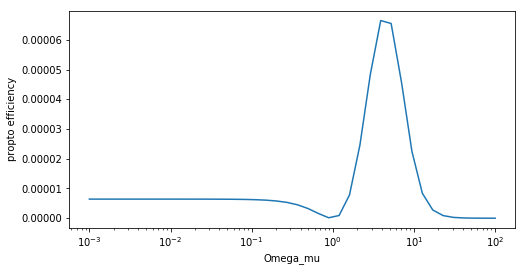

In [31]:
plt.semilogx(omegamvals,(np.abs(avals)/(omegamvals))**2)
plt.ylabel('propto efficiency')
plt.xlabel('Omega_mu');


## Time for some realistic simulations


In [32]:
# calculate microwave rabi frequency from power in in dBm
def omegam_from_Pin(Pin,p):
    mu0 = 4*pi*1e-7
    hbar=1.05457e-34; # in J*s
    Vsample=pi*((p['dsample']/2)**2) * p['Lsample'] # the volume of the Er:YSO sample
    V_microwave_cavity = Vsample/p['fillfactor']    
    mwP = 1e-3 * 10**(Pin/10)  #convert from dBm to Watts
    Q=2*pi*p['freqm']/(p['kappami']+p['kappamc']*2) # Q factor
    S21=(4*p['kappamc']**2)/(p['kappami']+p['kappamc']*2)**2
    energy_in_cavity=math.sqrt(S21)*2/(2*pi*p['freqm']/Q)*mwP; # energy inside the microwave cavity, in J
    Bmw=math.sqrt(mu0*(energy_in_cavity/V_microwave_cavity)/2); # Magnetic field of the microwave
    p['omegam']=(p['mu12']*Bmw)/hbar*(-1); # in rad/sec???? in Hz
    return p['omegam']

In [33]:
# calculate optical rabi frequency from power in in dBm
def omegao_from_Pin(Pin,p):
    epsilon0=8.854187817e-12
    hbar=1.05457e-34; # in J*s

    optP = 1e-3 * 10**(Pin/10) #incident optical power in W
    pflux = optP/(2*pi*p['freqo']*hbar) #photon flux (photons/sec)
    n_in = pflux * p['kappaoc']*4/(p['kappaoc']+p['kappaoi'])**2 # num intracavity photons
                                                #is this right????
    Sspot = pi*p['Wcavity']**2 #cross sectional area of
                                #optical mode
    V_cav = (Sspot*p['Lcavity_vac']+Sspot*p['Lsample']*p['nYSO']**3)/2;
    optEfield = math.sqrt(n_in*hbar*2*pi*p['freqo']/2/epsilon0/V_cav);
    p['omegao'] = p['d23']*optEfield/hbar*(-1);
    return p['omegao']

In [34]:
# parameters from Stephen via slack
# parameters commented out are not used in calculation
p = {}
p['a'] = 0
p['delta2'] = 0.
p['delta3'] = 0.


p['d13'] = 2e-32*math.sqrt(1/3)
p['d23'] = 2e-32*math.sqrt(2/3)
p['gamma13'] = p['d13']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma23'] = p['d23']**2/(p['d13']**2+p['d23']**2)*1/11e-3
p['gamma2d'] = 1e6
p['gamma3d'] = 1e6
p['nbath'] = 20
p['gammamu'] = 1/(p['nbath']+1) * 1/1e3

p['g'] = 51.9  #optical coupling
p['N'] = 1.28e15 # number of atoms in the optical mode

#try and make things a bit better conditioned
p['N']=1
p['g']=2e9

p['deltac']=0 #detuning for 
p['kappaoi']=2*pi*7.95e6 # intrinsic loss for optical resonator
p['kappaoc']=2*pi*1.7e6 # coupling loss for optical resonator
p['df']=0.1e6 # how small descretisation step to take when integrating over the 
            # inhomogeneous lines

p['mean_delta2']=0
p['sd_delta2']=2*pi*25e6/2.355  #microwave inhomogeneous broadening
                                #2.355is to turn FWHM into standard deviation
p['mean_delta3']=0
p['sd_delta3']=2*pi*170e6/2.355 #optical inhomogeneous broadening

p['kappami'] = 650e3*2*pi # intrinsic loss for microwave cavity
p['kappamc'] = 70e3*2*pi  # coupling loss for optical cavity
                        # this is for one of the two output ports
p['Nmu'] = 2.22e16  #toal number of atoms
p['gmu'] = 1.04 #coupling between atoms and microwave field


muBohr=927.4009994e-26; # Bohr magneton in J/T in J* T^-1
p['mu12'] = 4.3803*muBohr # transition dipole moment for microwave cavity (J T^-1)

p['Lsample']=12e-3 # the length of the sample, in m
p['dsample']=5e-3 # the diameter of the sample, in m

p['fillfactor']=0.8 #microwave filling factor
p['freqm'] = 5.186e9
p['freqo'] = 195113.36e9

p['Lcavity_vac'] = 49.5e-3 # length of the vacuum part of the optical
                           # Fabry Perot (m)
p['Wcavity'] =  0.6e-3# width of optical resonator beam in sample (m)
p['nYSO'] = 1.76 #refractive index of YSO


# assume 1mW (=0dBm) input to both optical and to microwave cavities
omegao_from_Pin(0,p)
omegam_from_Pin(0,p)

#see what rabi freqs we have
p['omegao']/1e6,p['omegam']/1e6

#%time ensemble_steady_rho13_integrated(p,p['df'])

In [35]:
p['df'] = 1e6
steadya(p)

a= [0 0] [0 0]
a= [0. 0.] [0. 0.]
a= [0. 0.] [0. 0.]
a= [1.49011612e-08 0.00000000e+00] [0. 0.]
a= [0.00000000e+00 1.49011612e-08] [0. 0.]
a= [1.31667635e-07 3.00540462e-07] [0. 0.]
a= [3.94190725e-07 9.01621559e-07] [0. 0.]
a= [9.14895219e-07 2.10378467e-06] [0. 0.]
a= [1.93962477e-06 4.50811435e-06] [0. 0.]
a= [4.02716312e-06 9.31676579e-06] [0. 0.]
a= [9.17382997e-06 1.89338406e-05] [0. 0.]
a= [1.60138337e-05 3.81687352e-05] [0. 0.]
a= [-1.09649688e-04  7.65401611e-05] [0. 0.]
a= [0.00204798 0.00011386] [0. 0.]
a= [-7.20489487e-05  9.63043414e-05] [0. 0.]
a= [-1.09649686e-04  7.65401611e-05] [0. 0.]
a= [-1.09649688e-04  7.65401623e-05] [0. 0.]
a= [-1.43687843e-04  7.44561969e-05] [0. 0.]
a= [-1.93791812e-04  4.82319087e-05] [0. 0.]
a= [-2.11758519e-04 -1.21207947e-05] [0. 0.]
a= [-2.16429251e-04 -2.50149147e-06] [0. 0.]
a= [-2.16341837e-04 -2.99210980e-06] [0. 0.]
a= [-2.16350620e-04 -3.00348763e-06] [0. 0.]
a= [-2.16352371e-04 -3.00459331e-06] [0. 0.]
a= [-2.16352495e-04 -3.0046721

(-0.0002163524947149412-3.0046721007370277e-06j)

In [36]:
p['df'] = 0.3e6 
%time steadya(p)

a= [-2.16352495e-04 -3.00467210e-06] [0. 0.]
a= [-2.16352495e-04 -3.00467210e-06] [0. 0.]
a= [-2.16352495e-04 -3.00467210e-06] [0. 0.]
a= [-2.16352491e-04 -3.00467210e-06] [0. 0.]
a= [-2.16352495e-04 -3.00467206e-06] [0. 0.]
a= [-2.16328663e-04 -2.95964434e-06] [0. 0.]
a= [-2.16328650e-04 -2.95964531e-06] [0. 0.]
a= [-2.16328650e-04 -2.95964531e-06] [0. 0.]
CPU times: user 2min 9s, sys: 1.08 s, total: 2min 10s
Wall time: 16.3 s


(-0.0002163286500295233-2.959645307697002e-06j)

In [37]:
#commented out because it takes and age to run

# omegamvals = np.logspace(-3,2,8)
# avals = np.zeros(omegamvals.shape,dtype='complex128')
# for i,omegam in enumerate(omegamvals):
#     p['omegam']=omegam
#     print("%d/%d"%(i+1,len(omegamvals)),end="")
#     avals[i] = steadya(p)
#     print(" -- completed")
    

In [38]:
# plt.semilogx(omegamvals,(np.abs(avals)/(omegamvals))**2,'x-')
# plt.ylabel('propto efficiency')
# plt.xlabel('Omega_mu')

In [39]:
!hostname

bb8


In [40]:
math.sqrt(p['N'])*p['g']/1e6